# Federal Tech Employees: Age and Demographic Analysis
#### US Digtal Corps Analysis - Bench Work 2024

Contributors:
- Colton Lapp (USDC '24 - colton.lapp@gsa.gov)

---

## Overview:
Goal is to understand the demographic breakdown of technologists in the Federal Government using the publicly available "FedScope Employment Data". 

## Data:
The data files are quite large as they contain anonymized individual level information for all individuals in the Federal Workforce (excludes contractors). The data is quarterly until 2010, and then annual from 2010 to 1998. 

By downloading, combining and filtering this data, we are able to create time series trends of the Federal Workforce. 

The data can be downloaded from this [open data website by the OPM](https://www.opm.gov/data/datasets/). Download every file titled "FedScope Employment Cube" and move the zip folder to `data/raw_data`, unzip the file, and rename it as **FedScope_{Month}Year** - i.e. **FedScope_Dec2023**. 

## Set Up

#### Import Modules

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os 
from tqdm import tqdm

#### Set up Pathing

In [33]:
# get root dir which ends in repo_name
repo_name = 'Fed_IT_Employment'
root = os.getcwd()
while os.path.basename(root) != repo_name:
    root = os.path.dirname(root)

# Get raw data directory
rdir = os.path.join( root, 'data', 'raw_data')

print(f"Base directory: {root}\nRaw data directory: {rdir}")

Base directory: /Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/Work/USDC/publicwork/Fed_IT_Employment
Raw data directory: /Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/Work/USDC/publicwork/Fed_IT_Employment/data/raw_data


## Set up dictionaries for file processing

In [34]:
# List of years for which data is available, for quarterly data and for September data (Mar, June, Dec are quarterly)

years_sep = [str(y) for y in range(1998, 2024)]
years_quart = [str(y) for y in range(2010, 2024)]


quarter_file_info = [
         { 'month':'MAR', 'years':years_quart},
         { 'month':'JUN', 'years':years_quart},
         { 'month':'SEP', 'years':years_sep},
         { 'month':'DEC', 'years':years_quart}
         ]

filenames = {
        'fedscope_folder' : 'FedScope_{}{}',
        'emp_data' : 'FACTDATA_{month}{year}.TXT',
        'age_codebook' : 'DTagelvl.txt',
        'loc_codebook' : 'DTloc.txt',
        }   


# Create mapping of column names to a more readble format
colname_map = {
    'AGYSUB' : 'agency',
    'LOC' : 'location',
    'AGELVL' : 'age',
    'EDLVL' : 'ed_level',
    'GSEGRD' : 'gen_sched_eq_grade',
    'LOSLVL' : 'length_of_service',
    'OCC' : 'occupation',
    'PATCO' : 'occupation_category',
    'PPGRD' : 'pay_plan_grade',
    'SALLVL' : 'salary_level',
    'STEMOCC' : 'stem_occ',
    'SUPERVIS' : 'supervisory_status',
    'TOA' : 'type_of_appointment',
    'WORKSCH' : 'work_schedule',
    'WORKSTAT' : 'work_status',
    'DATECODE' : 'date',
    'EMPLOYMENT' : 'employment',
    'SALARY' : 'avg_salary',
    'LOS' : 'avg_length_of_service'
}



### Functions to map categorically coded variables to readable values

Many categorical variables in FedScope employment data is categorical and represented as numbers/letters to make the files smaller. The codebook is then saved in a seperate file. These helper functions read in those codebook files and then convert the categorical columns to contain the human readable labels. 

In [35]:
def map_age(df, folder):
    """
    This function maps the AGELVL column to a more readable format using the age_codebook file
    """
    age_codebook = pd.read_csv(os.path.join( rdir, folder, filenames['age_codebook']))
    
    # turn age_codebook df into a dictionary mapping  column AGELVL to column AGELVLT
    age_dict = dict(zip(age_codebook['AGELVL'], age_codebook['AGELVLT']))

    # map AGELVL to AGELVLT
    df['age'] = df['age'].map(age_dict)
    return df

def map_location(df, folder):
    """
    This function maps the LOC column to a more readable format using the loc_codebook file
    """
    loc_codebook = pd.read_csv(os.path.join( rdir, folder, filenames['loc_codebook']))
    
    # turn loc_codebook df into a dictionary mapping  column LOC to column LOC_NAME
    loc_dict = dict(zip(loc_codebook['LOC'], loc_codebook['LOCT']))

    # map LOC to LOCT
    df.loc[:, 'location'] = df['location'].map(loc_dict)

    return df

def map_agency(df, folder):
    """
    This function uses AGYSUB to create two new columns by merging, AGYT and AGYSUBT
    """
    agency_codebook = pd.read_csv(os.path.join( rdir, folder, 'agency_codebook.csv'))
    agency_codebook = agency_codebook[['AGYSUB', 'AGYT', 'AGYSUBT']]

    # rename AGYSUB to agency
    agency_codebook.rename(columns={'AGYSUB':'agency'}, inplace=True)

    # drop duplicates
    agency_codebook.drop_duplicates(inplace=True)

    # Join columns AGYT and AGYSUBT
    df = pd.merge(df, agency_codebook, on='agency', how='left')

    # drop AGYSUB
    df.drop(columns='agency', inplace=True)

    return df

def map_ed_level(df, folder):
    """
    This function uses the EDLVL column to merge to two more columns: EDLVLTYPT and EDLVLT
    """
    ed_level_codebook = pd.read_csv(os.path.join( rdir, folder, 'ed_level_codebook.csv'))
    
    # rename EDLVL to ed_level
    ed_level_codebook.rename(columns={'EDLVL':'ed_level'}, inplace=True)

    # drop duplicates
    ed_level_codebook.drop_duplicates(inplace=True)

    # Join columns EDLVLTYPT and EDLVLT
    df = pd.merge(df, ed_level_codebook, on='ed_level', how='left')

    # drop EDLVL
    df.drop(columns='ed_level', inplace=True)

    return df


def map_date(df):
    # convert date to datetime with format YYYYMM
    df.loc[:, 'date'] = pd.to_datetime(df['date'], format='%Y%m')

    # return
    return df

## Read in all datasets, convert categorical columns, append together

In [36]:
# Columns we want to keep in processed dataset
cols_keep = ['agency', 'location', 'age', 'ed_level', 'occupation', 'occupation_category', 'pay_plan_grade', 'date']

# Container for concatenated data
concat_df = pd.DataFrame()

# Loop through each quarter and year, read in the data, and concatenate to concat_df
for my_dict in quarter_file_info:
  for year in tqdm(my_dict['years'], desc=f"Processing years for quarter ending in month {my_dict['month']}"):

      # get folder and filename
      folder = filenames['fedscope_folder'].format(my_dict['month'].title(), year)
      fname = filenames['emp_data'].format(month=my_dict['month'], year=year)

      # read in data
      df = pd.read_csv(os.path.join(rdir, folder, fname), low_memory=False)

      # rename df columns
      df.rename(columns=colname_map, inplace=True)
      
      # subset columns of interest
      df = df[cols_keep]

      # Convert age, date, and location columns to more readable format
      df = map_age(df, folder)
      df = map_date(df)
      df = map_location(df, folder)

      # concat df to concat_df
      concat_df = pd.concat([concat_df, df], axis=0)




Processing years for quarter ending in month DEC: 100%|██████████| 14/14 [02:11<00:00,  9.36s/it]


### Concatenated, Processed, and Mapped Final Dataset to Save

In [37]:
# Show the first few rows of the concatenated data
concat_df 

,agency,location,age,ed_level,occupation,occupation_category,pay_plan_grade,date
0,AA00,11-DISTRICT OF COLUMBIA,65 or more,21,0301,2,EX-02,2010-03-01
1,AB00,IT-ITALY,60-64,07,1630,2,GS-12,2010-03-01
2,AB00,FR-FRANCE,50-54,04,1630,2,GS-12,2010-03-01
3,AB00,BE-BELGIUM,60-64,04,1630,2,GS-12,2010-03-01
4,AB00,FR-FRANCE,55-59,17,0301,2,GS-15,2010-03-01
...,...,...,...,...,...,...,...,...
2261277,ZS00,11-DISTRICT OF COLUMBIA,30-34,04,0301,2,AD-00,2023-12-01
2261278,ZS00,11-DISTRICT OF COLUMBIA,25-29,13,0301,2,AD-00,2023-12-01
2261279,ZS00,11-DISTRICT OF COLUMBIA,30-34,04,0301,2,AD-00,2023-12-01
2261280,ZS00,51-VIRGINIA,35-39,17,0301,2,AD-00,2023-12-01


#### Write merged and processed dataset to file

In [38]:
concat_df.to_csv(os.path.join(root, 'data', 'processed_data', 'FedScope_emp_data_concat.csv'), index=False)

# Analysis

---


## 1. Distribution of age in December 2023 (latest data)

Show distribution for both:
- IT Jobs
- All Federal Jobs

In [79]:
# IT series codes to include as "Tech workers"
IT_series = [
    '2210' # IT Management
    #,'1515' # OR
    #,'1550' # Comp Sci
    #,'1520' # Math
    #,'1560' # Data Science
]

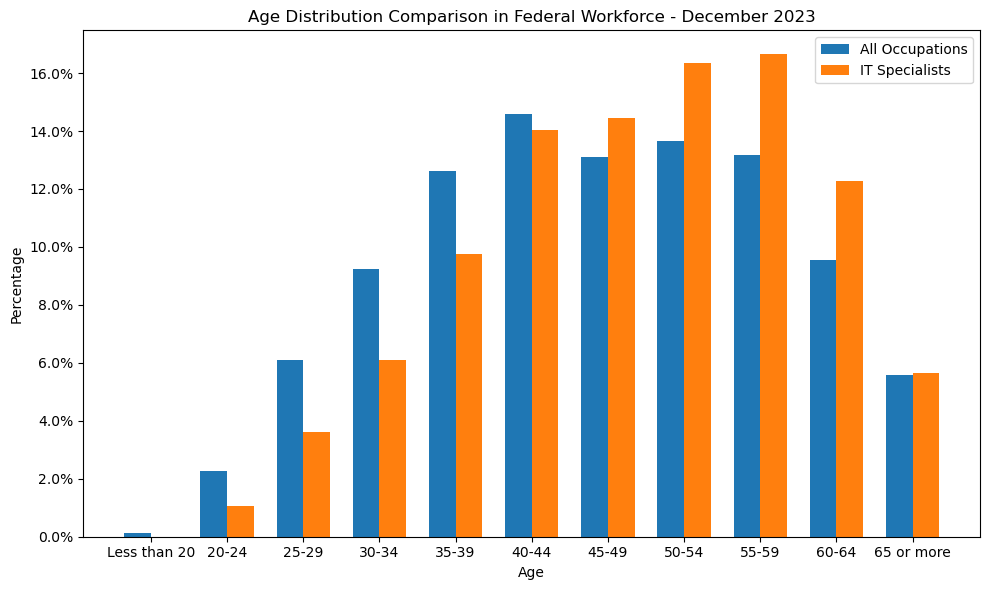

In [80]:
# ---------------------- Filter Data and Calculate Counts/Percentages ----------------------#

dec_2023 = pd.to_datetime('20231201', format='%Y%m%d')

# Subset the data to only include December 2023
df_2023 = concat_df[concat_df['date'] == dec_2023]

# Subset the data to only include IT specialists
df_IT = df_2023[df_2023['occupation'].isin(IT_series)]

# cateogrical order of ages (for plotting)
ages = ['Less than 20', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65 or more']


# Filter ages to only include those in df_IT 
ages = [age for age in ages if age in df_IT['age'].unique()]

# Calculate value counts as percentages
age_counts_all = df_2023['age'].value_counts(normalize=True).loc[ages] * 100

# Calculate value counts as percentages
age_counts_IT = df_IT['age'].value_counts(normalize=True).loc[ages] * 100


# --------------------- Make Bar Graph --------------------#

# Create the grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define the positions for the bars
bar_width = 0.35
index = range(len(ages))

# Plot the bars
bars_all = ax.bar(index, age_counts_all, bar_width, label='All Occupations')
bars_IT = ax.bar([i + bar_width for i in index], age_counts_IT, bar_width, label='IT Specialists')

# Add labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Percentage')
ax.set_title('Age Distribution Comparison in Federal Workforce - December 2023')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(ages)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()

plt.tight_layout()
plt.show()

## 2. Visualize Time Series of Age Composition Over Time

For each unique date, calculate percentage of workforce in each age group for entire dataset and IT workforce 

In [81]:
# --------------------- Calculate Age Distribution Over Time --------------------#

# Create a dictionary to store the results
age_counts = {}

# Iterate over the unique dates
for date in concat_df['date'].unique():

    # Subset the data to the current date
    df_date = concat_df[concat_df['date'] == date]
    # Subset IT workers
    df_date_IT = df_date[df_date['occupation'].isin(IT_series)] 

    # Subset the age groups that are present in the data
    ages_in_df = [age for age in ages if age in df_date_IT['age'].unique()]
    
    # Calculate the percentage of workers in each age group
    age_counts_all = df_date['age'].value_counts(normalize=True).loc[ages_in_df] * 100
    age_counts_IT = df_date_IT['age'].value_counts(normalize=True).loc[ages_in_df] * 100
    
    # Make date key by dropping time from date
    date_key = date.date()

    # Store the results in the dictionary
    age_counts[date_key] = {'All Occupations': age_counts_all, 'IT Specialists': age_counts_IT}
    

# Show example of first date in the dictionary
for my_dict in age_counts:
    print(f"Date: {my_dict}")
    for age, percentage in age_counts[my_dict]['IT Specialists'].items():
        print(f"\t Age: {age} - Percentage: {percentage:.2f}%")

    break

Date: 2010-03-01
	 Age: Less than 20 - Percentage: 0.01%
	 Age: 20-24 - Percentage: 0.75%
	 Age: 25-29 - Percentage: 4.17%
	 Age: 30-34 - Percentage: 6.83%
	 Age: 35-39 - Percentage: 9.29%
	 Age: 40-44 - Percentage: 13.75%
	 Age: 45-49 - Percentage: 20.36%
	 Age: 50-54 - Percentage: 20.39%
	 Age: 55-59 - Percentage: 14.89%
	 Age: 60-64 - Percentage: 7.40%
	 Age: 65 or more - Percentage: 2.16%


In [82]:
# --------------------- Create Time Series of Specific Age Categories --------------------#

# Create a DataFrame to store the results
df_age = pd.DataFrame()

# List to store rows to concatenate later into a DF
rows = []

for date, counts in age_counts.items():
    if counts['All Occupations'].shape[0] != 0 :
        # Create a dictionary to store calculations we want to graph
        row = {'date': date, 
               'ages_20_to_29': counts['All Occupations'].loc['20-24'] + counts['All Occupations'].loc['25-29'],

               'ages_20_to_29_IT': counts['IT Specialists'].loc['20-24'] + counts['IT Specialists'].loc['25-29'],

               'ages_30_to_49': counts['All Occupations'].loc['30-34'] + counts['All Occupations'].loc['35-39'] + 
                                            counts['All Occupations'].loc['40-44'] + counts['All Occupations'].loc['45-49'],
        
                'ages_30_to_49_IT': counts['IT Specialists'].loc['30-34'] + counts['IT Specialists'].loc['35-39'] +
                                            counts['IT Specialists'].loc['40-44'] + counts['IT Specialists'].loc['45-49'],
        
                # 50 and older
                'ages_50_or_more': counts['All Occupations'].loc['50-54'] + counts['All Occupations'].loc['55-59'] +
                                            counts['All Occupations'].loc['60-64'] + counts['All Occupations'].loc['65 or more'],

                'ages_50_or_more_IT': counts['IT Specialists'].loc['50-54'] + counts['IT Specialists'].loc['55-59'] +
                                            counts['IT Specialists'].loc['60-64'] + counts['IT Specialists'].loc['65 or more']
                }


        # Append the dictionary to the list
        rows.append(row)


# Concatenate all DataFrames in the list
df_age = pd.DataFrame(rows)

df_age.head()

,date,ages_20_to_29,ages_20_to_29_IT,ages_30_to_49,ages_30_to_49_IT,ages_50_or_more,ages_50_or_more_IT
0,2010-03-01,10.601569,4.918890,47.154134,50.230594,41.966841,44.841132
1,2011-03-01,10.442519,4.941889,47.150795,50.586093,42.186307,44.463288
2,2012-03-01,9.556960,4.410464,47.349507,50.302137,42.942792,45.278801
3,2013-03-01,8.824611,4.038778,47.505263,49.377905,43.575119,46.577266
4,2014-03-01,7.775665,3.470156,47.428115,47.985785,44.746123,48.537911


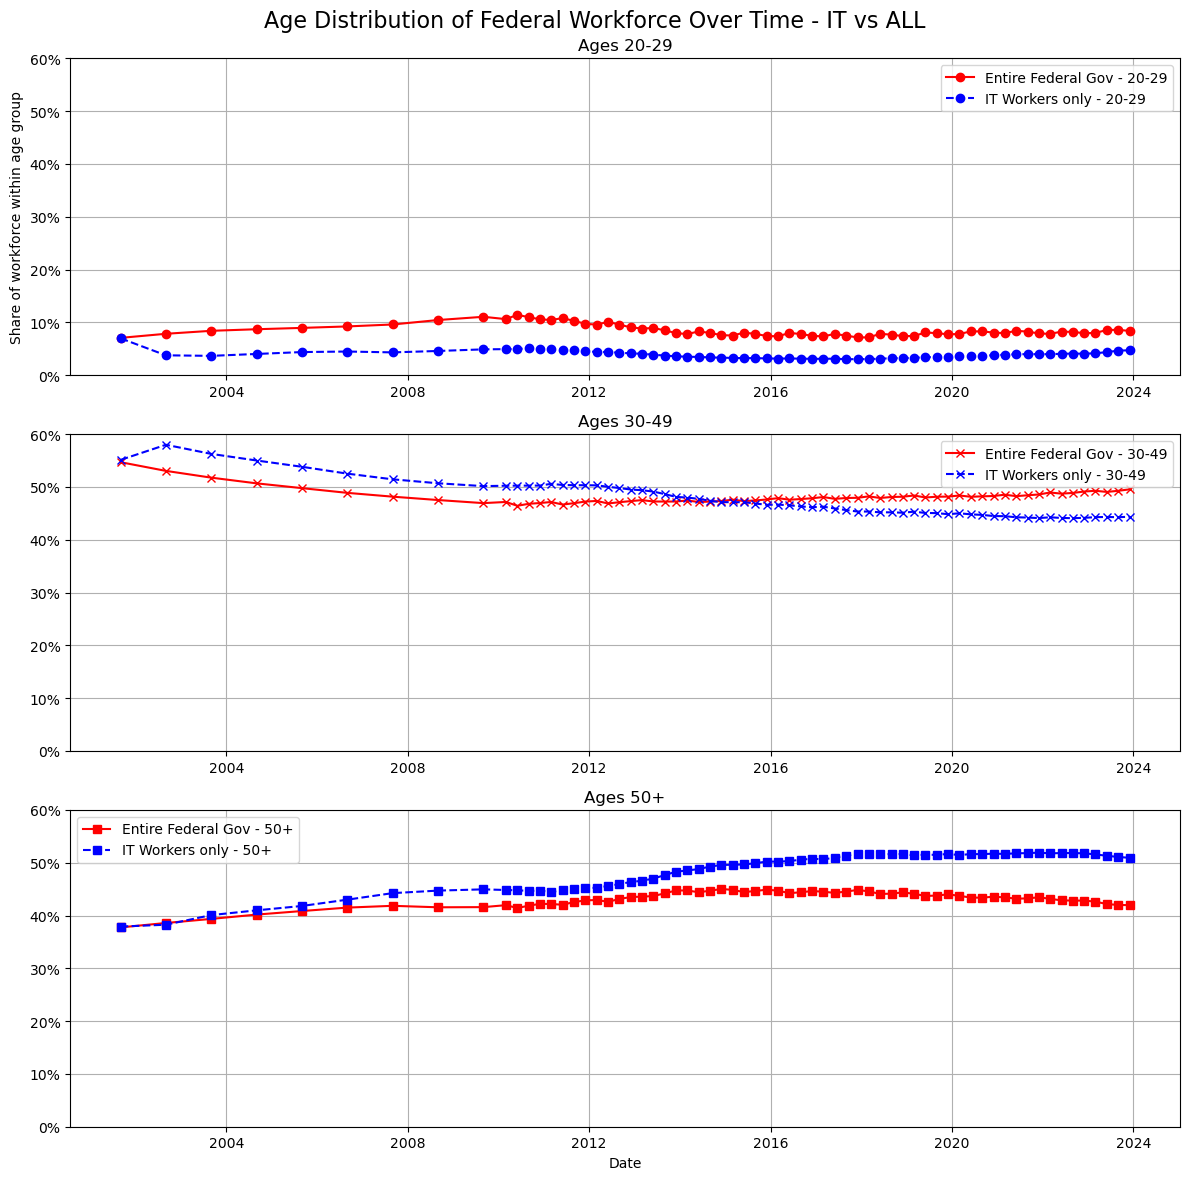

In [87]:
# --------------------- Create Time Series of Specific Age Categories --------------------#

# Set the plot size
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 3 rows, 1 column for subplots

# Sort by date
df_age = df_age.sort_values('date')

# Plot the 20-29 age group on the first subplot
axes[0].plot(df_age['date'], df_age['ages_20_to_29'], color='red', linestyle='-', marker='o', label='Entire Federal Gov - 20-29')
axes[0].plot(df_age['date'], df_age['ages_20_to_29_IT'], color='blue', linestyle='--', marker='o', label='IT Workers only - 20-29')
axes[0].set_ylim(0, 60)
axes[0].set_title('Ages 20-29')
axes[0].set_ylabel('Share of workforce within age group')
axes[0].legend()
axes[0].grid(True)

# Plot the 30-49 age group on the second subplot
axes[1].plot(df_age['date'], df_age['ages_30_to_49'], color='red', linestyle='-', marker='x', label='Entire Federal Gov - 30-49')
axes[1].plot(df_age['date'], df_age['ages_30_to_49_IT'], color='blue', linestyle='--', marker='x', label='IT Workers only - 30-49')
axes[1].set_title('Ages 30-49')
axes[0].set_ylabel('Share of workforce within age group')
axes[1].set_ylim(0, 60)
axes[1].legend()
axes[1].grid(True)

# Plot the 50 or more age group on the third subplot
axes[2].plot(df_age['date'], df_age['ages_50_or_more'], color='red', linestyle='-', marker='s', label='Entire Federal Gov - 50+')
axes[2].plot(df_age['date'], df_age['ages_50_or_more_IT'], color='blue', linestyle='--', marker='s', label='IT Workers only - 50+')
axes[2].set_title('Ages 50+')
axes[2].set_xlabel('Date')
axes[2].set_ylim(0, 60)
axes[0].set_ylabel('Share of workforce within age group')
axes[2].legend()
axes[2].grid(True)

# Format the y-axis as a percentage for all subplots
for ax in axes:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Set title for entire plot
fig.suptitle('Age Distribution of Federal Workforce Over Time - IT vs ALL', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()